# libraries

In [1]:
## Standard library imports
import os
import re
import shutil
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Any

## visualization
from tqdm import tqdm
import matplotlib.pyplot as plt

## preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Model
### Machine Learning
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_fscore_support
### Transformers
import torch
from torch.optim import AdamW
from transformers import EarlyStoppingCallback
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

c:\Users\Mohammed237\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NLTK setup

In [2]:
def download_nltk_resources(resources: List[str]):
    for resource in resources:
        try:
            nltk.download(resource, quiet=True)
        except Exception as e:
            print(f"Warning: Failed to download {resource}: {str(e)}")

try:
    required_resources = [
        'punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'
    ]
    download_nltk_resources(required_resources)
    print("✅ NLTK setup completed successfully.")
except Exception as e:
    print(f"❌ Error during NLTK setup: {str(e)}")
    raise

✅ NLTK setup completed successfully.


# Data

## load data

In [5]:
# df = pd.read_excel("/kaggle/input/movies-reviews-sentiment-data/sentiment_data.xlsx", engine='openpyxl')
df = pd.read_csv("NLP_Data/all_reviews.csv")

## data overview

In [6]:
df.head(10)

,review,label
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0
5,"the story is also as unoriginal as they come ,...",0
6,about the only thing to give the movie points ...,0
7,not so much farcical as sour .,0
8,unfortunately the story and the actors are ser...,0
9,all the more disquieting for its relatively go...,0


In [7]:
df.shape

(10662, 2)

the shape of the data is **``(10662, 2)``**

In [8]:
df.label.value_counts()

label
0    5331
1    5331
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  10662 non-null  object
 1   label   10662 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 166.7+ KB


In [7]:
df.isnull().sum()

review    0
label     0
dtype: int64

there are no nulls in the data

In [8]:
df.duplicated().sum()

0

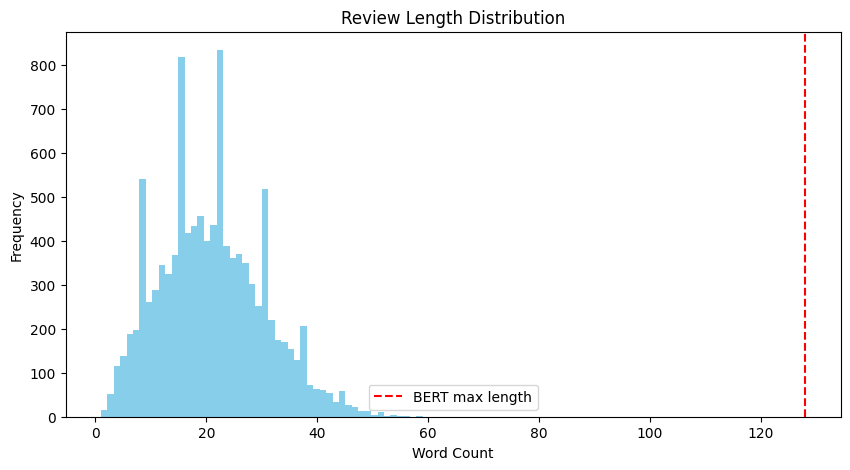

Max length: 59
Min length: 1
Average length: 21.0
Reviews > 128 words: 0.0%


In [9]:
# Calculate text lengths
df['text_length'] = df['review'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(10,5))
plt.hist(df['text_length'], bins=50, color='skyblue')
plt.axvline(x=128, color='red', linestyle='--', label='BERT max length')
plt.title('Review Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Show statistics
print(f"Max length: {df['text_length'].max()}")
print(f"Min length: {df['text_length'].min()}")
print(f"Average length: {df['text_length'].mean():.1f}")
print(f"Reviews > 128 words: {len(df[df['text_length']>128])/len(df):.1%}")

# Preprocessing

## normal preprocessing

## handle duplicates

In [10]:
df.drop_duplicates(inplace=True)

## text preprocessing

### clean text

In [11]:
def clean_text(text: str) -> str:
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### stop words removal

In [12]:
def remove_stopwords(text: str) -> str:
    # Define stop words and keep important sentiment-related words
    stop_words = set(stopwords.words('english'))
    important_words = {
        'not', 'no', 'never', 'very', 'really', 'too', 'so', 
        'much', 'many', 'few', 'little', 'hardly', 'barely', 'scarcely'
    }
    stop_words -= important_words

    # Use regex to remove stopwords while preserving spacing
    # Create a pattern to match whole stopwords only
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in stop_words) + r')\b'
    
    # Remove stopwords (replace them with space)
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

### repeated character

In [13]:
def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

### remove duplicate words

In [14]:
def remove_duplicate_ngrams_multi(text, max_n=3):
    words = text.split()
    i = 0
    result = []
    seen = set()

    while i < len(words):
        matched = False
        for n in range(max_n, 0, -1):
            if i + n <= len(words):
                ngram = tuple(words[i:i + n])
                if ngram not in seen:
                    seen.add(ngram)
                    result.extend(ngram)
                    i += n
                    matched = True
                    break  # break inner loop if match found
        if not matched:
            # if no match (e.g., remaining words < max_n), just add word
            result.append(words[i])
            i += 1
    return ' '.join(result)

### lemmatization

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
def lemmatize_text(text: str) -> str:
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

### text process

In [17]:
def preprocess_text(text: str) -> str:
    # lower case
    text = text.lower()
    # clean text
    text = clean_text(text)
    # remove repeated chars
    text = normalize_repeated_chars(text)
    # Remove duplicate n-grams
    for n in range(3, 0, -1):
        text = remove_duplicate_ngrams_multi(text, max_n=n)
    # stop words removal
    text = remove_stopwords(text)
    # lemmatization
    text = lemmatize_text(text)
    return text

## Apply text preprocessing

In [18]:
df['processed_text'] = df['review'].apply(preprocess_text)

In [19]:
num_of_sample = 0
print(f"original text: {df['review'][num_of_sample]}")
print('----------------------')
print(f"processed text: {df['processed_text'][num_of_sample]}")

original text: simplistic , silly and tedious .
----------------------
processed text: simplistic silly tedious


## handle long text reviews

### truncation

In [20]:
max_length = 512

In [21]:
def preprocess_data(examples):
    # Tokenize with truncation
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=max_length)

In [22]:
texts = df['processed_text'].tolist()
labels = df['label'].tolist()

# Models

## ML approach

### split data

In [23]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(texts)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

### train

In [24]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVC': LinearSVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # print(f"\n{name} Classification Report:")
    # print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

print("All models trained")


Training Logistic Regression...

Training Linear SVC...

Training Random Forest...
All models trained


### evaluate

In [25]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.76      0.74      1062
    Positive       0.75      0.71      0.73      1071

    accuracy                           0.73      2133
   macro avg       0.74      0.73      0.73      2133
weighted avg       0.74      0.73      0.73      2133


Linear SVC Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.77      0.76      1062
    Positive       0.76      0.74      0.75      1071

    accuracy                           0.75      2133
   macro avg       0.75      0.75      0.75      2133
weighted avg       0.75      0.75      0.75      2133


Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.82      0.73      1062
    Positive       0.77      0.58      0.66      1071

    accuracy                           0.70      2133
   macro av

## BERT Model

### parameters

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16         # batch size
MAX_LENGTH = 128        # max length of the input text
LEARNING_RATE = 2e-5    # learning rate (reduced from 5e-5 for better stability)
NUM_EPOCHS = 10         # number of epochs
PATIENCE = 2            # early stopping
LOGGING_STEPS = 50      # log training metrics every N steps

### load tokenizer

In [27]:
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

### load model

In [28]:
model = BertForSequenceClassification.from_pretrained(
    "textattack/bert-base-uncased-SST-2",
    num_labels=2
).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

### prepare data

In [29]:
class ReviewDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer: BertTokenizer):
        self.encodings = tokenizer(
            texts,
            padding='longest',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self) -> int:
        return len(self.labels)

In [30]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)
test_dataset = ReviewDataset(test_texts, test_labels, tokenizer)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("train shape: ", train_dataset.__len__())
print("train shape: ", val_dataset.__len__())
print("train shape: ", test_dataset.__len__())

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

train shape:  7463
train shape:  1599
train shape:  1600


### Training

In [31]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

best_val_accuracy = 0
patience_counter = 0

In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [33]:
### Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=200,
    weight_decay=0.01,
    learning_rate=LEARNING_RATE,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=100,
    eval_strategy='steps',
    save_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    gradient_accumulation_steps=2,
    seed=42,
    report_to="none",
    disable_tqdm=False,
)

### Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Starting training...")
trainer.train()
print("Training completed.")

Starting training...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.503400,0.385393,0.838649,0.839477,0.838649,0.838638
200,0.394400,0.358774,0.838649,0.839786,0.838649,0.838393
300,0.296900,0.408246,0.849281,0.849333,0.849281,0.849291
400,0.286000,0.403654,0.845528,0.845960,0.845528,0.845538
500,0.243200,0.521541,0.841151,0.842620,0.841151,0.840847
600,0.125400,0.554574,0.833021,0.834851,0.833021,0.832633
700,0.140000,0.525818,0.842402,0.842478,0.842402,0.842355
800,0.082500,0.905030,0.820513,0.829661,0.820513,0.818879
900,0.085900,0.805136,0.844903,0.845366,0.844903,0.844911
1000,0.059900,0.899595,0.838024,0.838140,0.838024,0.837964


Training completed.


In [34]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

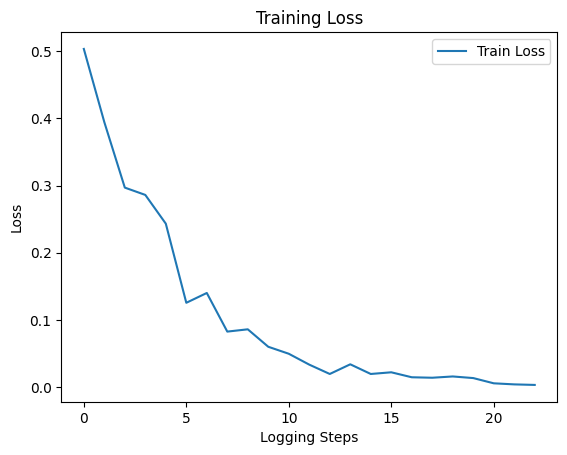

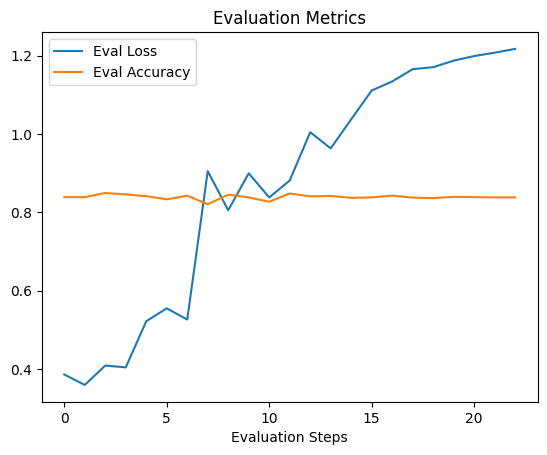

In [35]:
# Extract loss and accuracy from logs
train_loss = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plot training loss
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot eval loss and accuracy
plt.plot(eval_loss, label='Eval Loss')
plt.plot(eval_accuracy, label='Eval Accuracy')
plt.xlabel('Evaluation Steps')
plt.title('Evaluation Metrics')
plt.legend()
plt.show()

### Evaluation

In [36]:
### Manual evaluation since evaluation_strategy isn't available
print("\nEvaluating on validation set...")
val_results = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation Accuracy: {val_results['eval_accuracy']:.4f}")

print("\nEvaluating on test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")


Evaluating on validation set...


Validation Accuracy: 0.8386

Evaluating on test set...
Test Accuracy: 0.8387


### save model and tokenizer

In [37]:
### Save the best model
best_model_path = "./best_bert_model"
trainer.save_model(best_model_path)
tokenizer.save_pretrained(best_model_path)
print(f"\nBest model saved to {best_model_path}")


Best model saved to ./best_bert_model


In [38]:
shutil.make_archive("best_bert_model", 'zip', best_model_path)
print("Model folder compressed to best_bert_model.zip")

Model folder compressed to best_bert_model.zip


## test model

In [39]:
model_path = "/kaggle/input/bert_model_movies_reviews_sentiment/pytorch/default/1"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [40]:
texts = test_texts[:5]
encodings = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="pt"
)

In [41]:
label_map = {0: "negative", 1: "positive"}

model.eval()
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Print text and predicted label decoded
for text, pred_label in zip(test_texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted Label: {label_map[int(pred_label)]}")
    print("-----")

Text: overwrought melodramatic bodiceripper
Predicted Label: negative
-----
Text: lead so unmemorable despite several attempt lengthy dialogue scene one eventually resents inhale gutter romancers secondhand material
Predicted Label: negative
-----
Text: leguizamo jones excellent rest cast uniformly superb
Predicted Label: positive
-----
Text: would hard think recent movie worked hard achieve little fun
Predicted Label: negative
-----
Text: suffocating rapepayback horror show hinge subgenres enabling victim ebullient affection industrialmodel meat freezer
Predicted Label: negative
-----


# End